In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.ticker import MaxNLocator

In [2]:
folder_path = '../data'
datasets = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

In [3]:
def plot(dataset, figsize):
    # Define the desired order of methods with 'rf' renamed to 'mmif'
    desired_order = ['constant', 'knn', 'linear', 'mmit', 'mmif', 'aft_xgb', 'mlp']

    # Read the size of the dataset
    datasize = pd.read_csv(f'../data/{dataset}/targets.csv').shape[0]
    n_features = pd.read_csv(f'../data/{dataset}/features.csv').shape[1]

    # Load the CSV file
    df = pd.read_csv(f'../loss_csvs/{dataset}.csv')

    # Replace 'rf' with 'mmif' in the 'method' column
    df['method'] = df['method'].replace({'rf': 'mmif', 'aft_xgboost_original': 'aft_xgb'})

    # Filter the dataframe based on the desired order of methods
    df = df[df['method'].isin(desired_order)]

    # Drop rows with NaN values
    df = df.dropna()

    # Calculate the mean loss for each method
    mean_loss_per_method = df.groupby('method')['loss'].mean()

    # Identify the top 2 methods with the highest mean loss
    methods_to_remove = mean_loss_per_method.nlargest(2).index

    # Remove rows corresponding to the methods with the highest mean loss
    df = df[~df['method'].isin(methods_to_remove)]

    # Update desired_order to remove the methods with the highest mean loss
    desired_order = [method for method in desired_order if method not in methods_to_remove]

    # Filter methods and ensure the desired order
    df['method'] = pd.Categorical(df['method'], categories=desired_order, ordered=True)
    df = df.sort_values('method')

    # Create a figure with 3 subplots (one for each plot)
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Set the suptitle for the figure
    plt.suptitle(f"{dataset} ({datasize} instances -- {n_features} features)", fontsize=12)

    # Adjust spacing to give more room between suptitle and subplots
    plt.subplots_adjust(top=0.77)  # Adjust the 'top' value to create more space

    # First plot: scatter plot of all loss values for each method
    ax1 = axes[0]
    for method in desired_order:
        method_losses = df[df['method'] == method]['loss']
        ax1.scatter(method_losses, [method] * len(method_losses), alpha=0.6, color='white', edgecolors='black')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax1.set_ylabel('Method')
    ax1.set_xlabel('test_squared_hinge_loss')
    ax1.set_title('test fold error')
    ax1.set_ylim(-0.5, len(desired_order) - 0.5)
    ax1.set_yticks(np.arange(len(desired_order)))  # Ensure y-ticks match the method indices
    ax1.set_yticklabels(desired_order)  # Set y-ticks to be the method names
    ax1.grid(True)

    means = []
    sds = []
    for method in desired_order:
        method_losses = df[df['method'] == method]['loss']
        means.append(method_losses.mean())
        sds.append(0.5 * method_losses.std())

    # Plot mean ± SD
    ax2 = axes[1]
    y_pos = np.arange(len(desired_order))
    ax2.errorbar(means, y_pos, xerr=sds, fmt='o', color='black', ecolor='gray', capsize=5, label='Mean ± SD')
    ax2.set_yticks(np.arange(len(desired_order)))  # Ensure y-ticks match the method indices
    ax2.set_yticklabels([])  # No method labels on the y-axis for this plot
    ax2.set_xlabel('test_squared_hinge_loss')
    ax2.set_title(f"Mean ± SD")
    ax2.set_ylim(-0.5, len(desired_order) - 0.5)
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax2.grid(True)

    # Third plot: boxplot showing only the 25-75 percentile box with similar style to second plot
    ax3 = axes[2]

    # Plot box without whiskers, outliers, and median line
    ax3.boxplot([df[df['method'] == method]['loss'] for method in desired_order], 
                vert=False, patch_artist=True, widths=0.5, showmeans=False, 
                showfliers=False,  # Remove the outliers
                medianprops=dict(color='black'),  # Show the median line
                boxprops=dict(facecolor='lightgray', color='black'),  # Box properties match the second figure style
                whiskerprops=dict(color='none'))  # Hide whiskers (no interval line)

    ax3.set_yticks(np.arange(len(desired_order)) + 1)  # Align y-ticks with the method indices
    ax3.set_yticklabels([])  # No method labels on the y-axis for this plot
    ax3.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax3.set_xlabel('test_squared_hinge_loss')
    ax3.set_title('25-75 Percentile Box (IQR)')
    ax3.grid(True)

    # Save the plot as a PNG or JPG in the 'pdfs' folder
    if not os.path.exists('pdfs/datasets'):
        os.makedirs('pdfs/datasets')  # Create the 'pdfs' folder if it doesn't exist

    # Save as PDF with tight bounding box and high DPI for better quality
    plt.savefig(f'pdfs/datasets/{dataset}_plot.pdf', dpi=300, bbox_inches='tight')

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Show the plot (optional)
    plt.show()

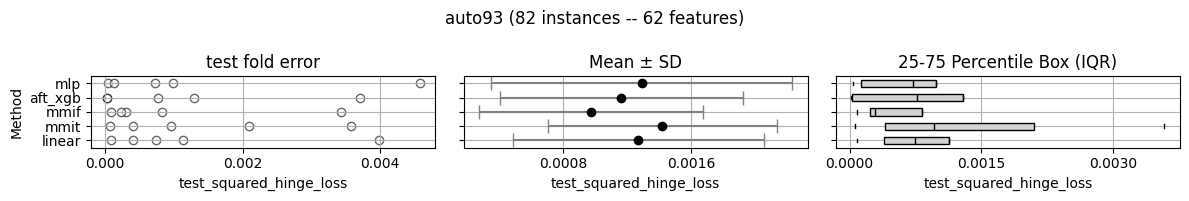

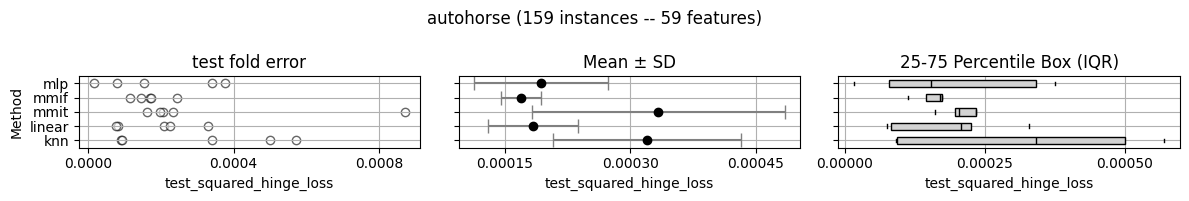

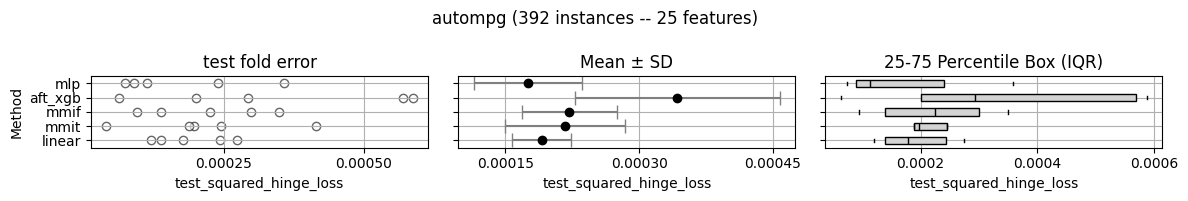

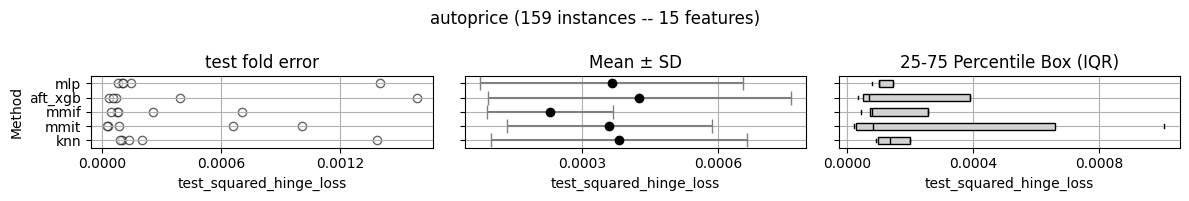

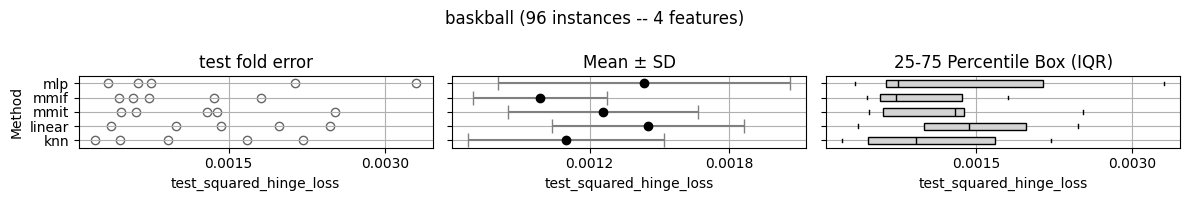

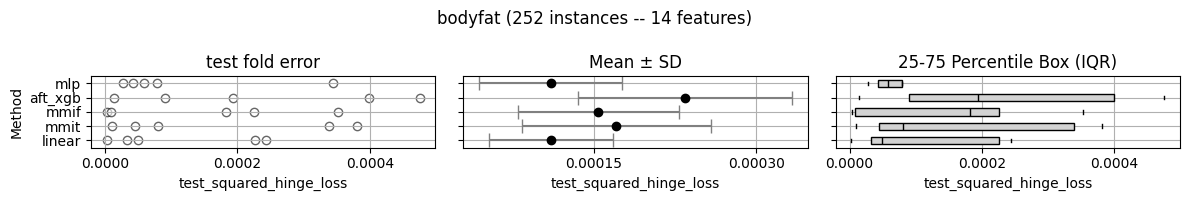

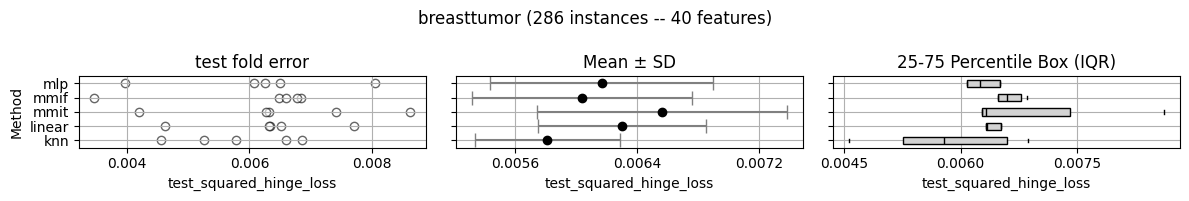

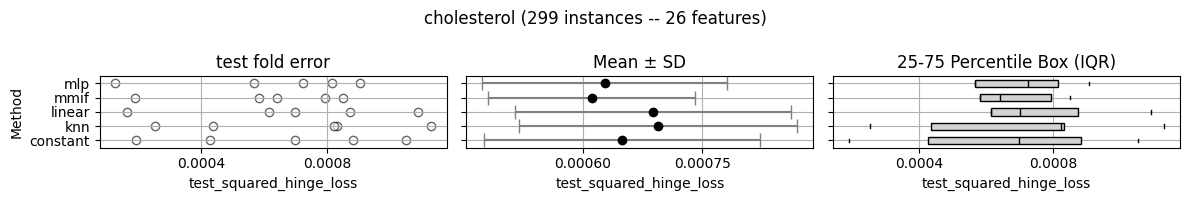

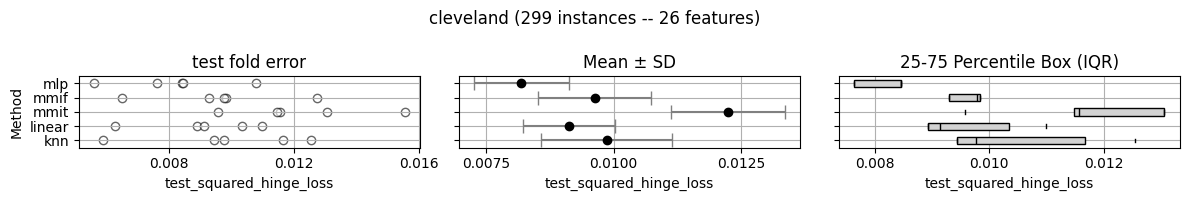

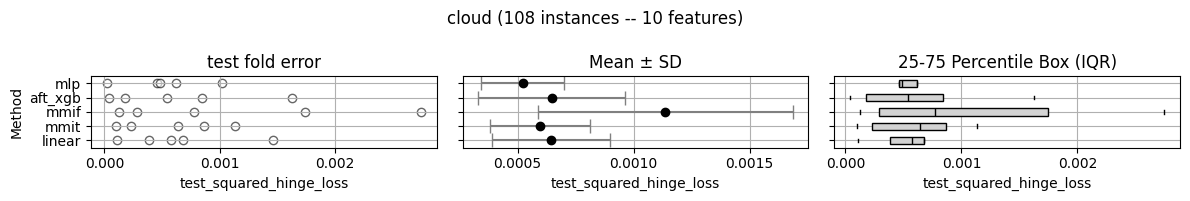

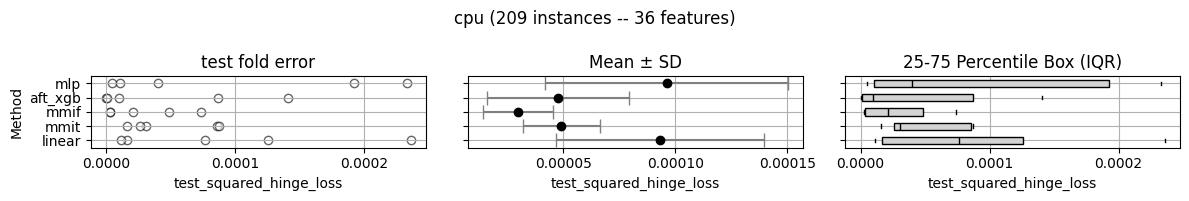

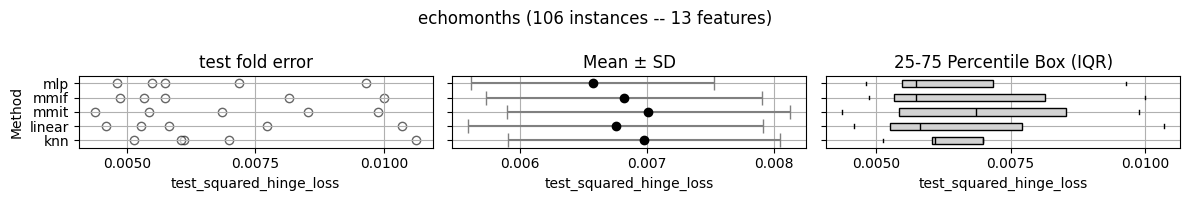

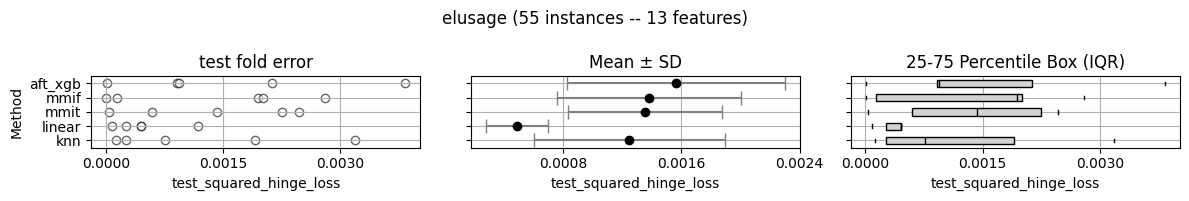

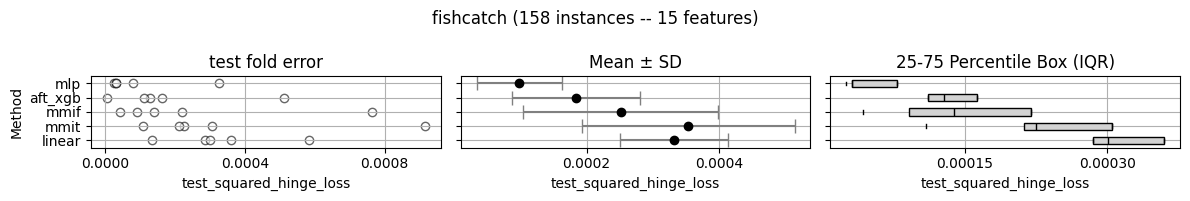

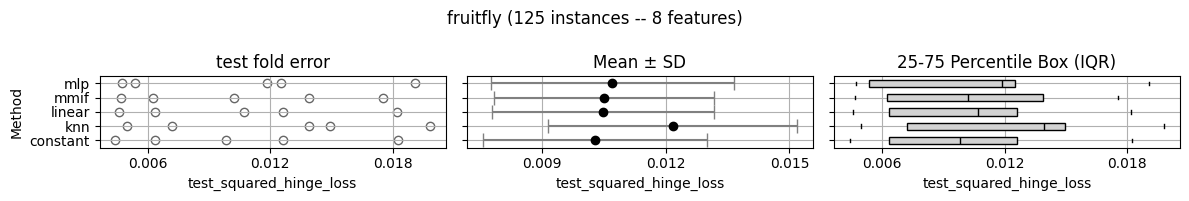

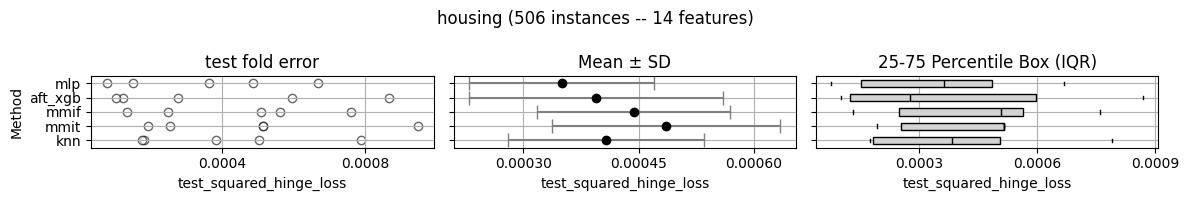

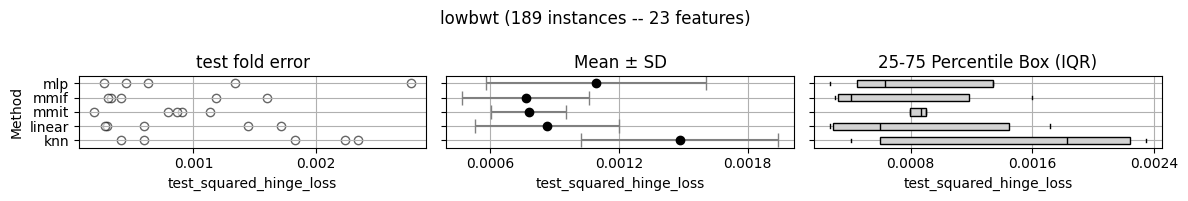

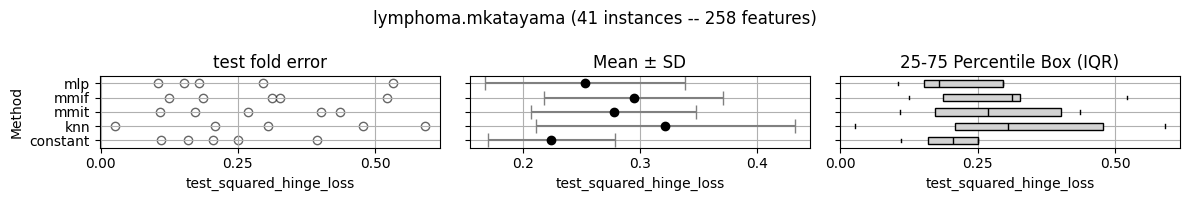

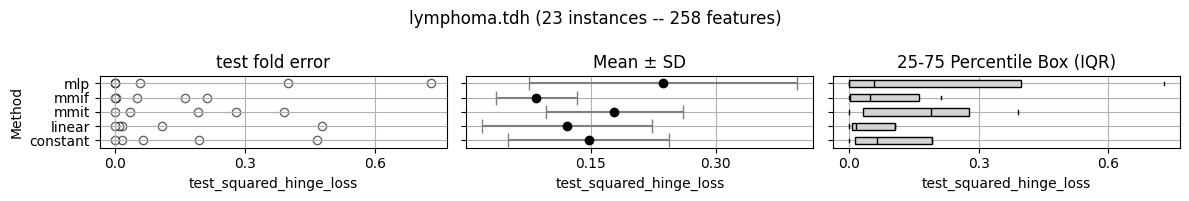

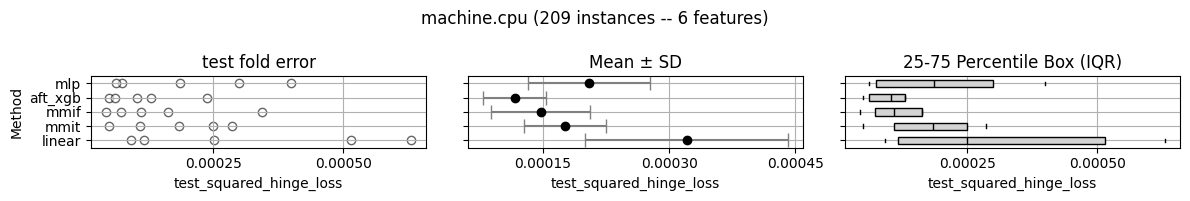

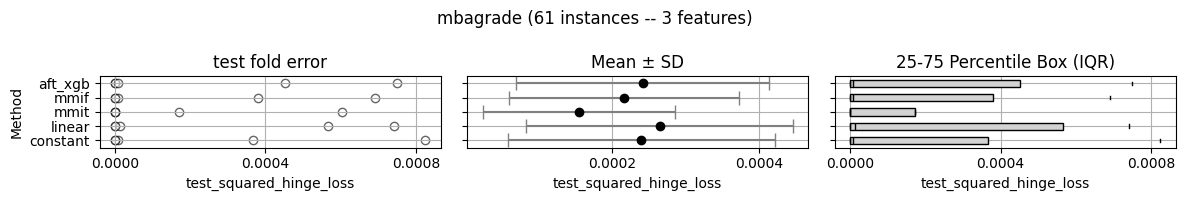

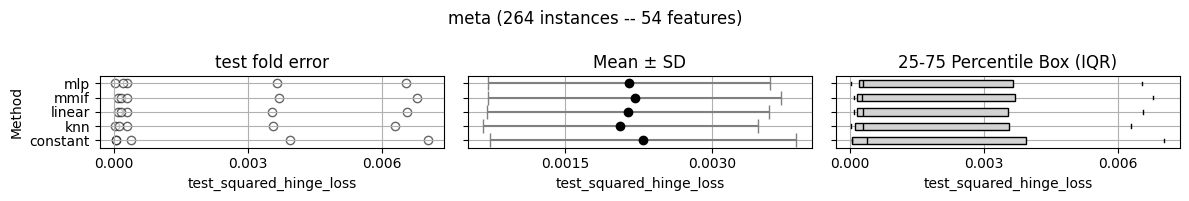

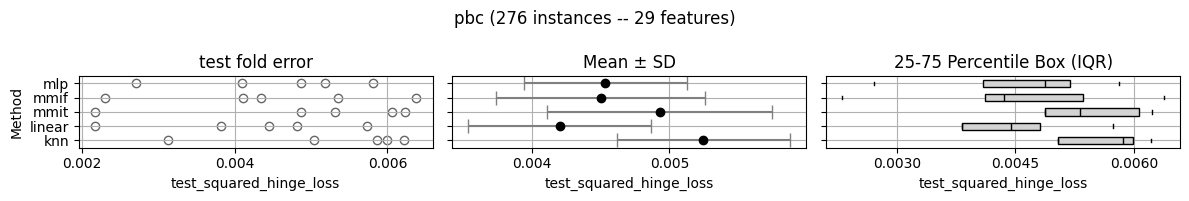

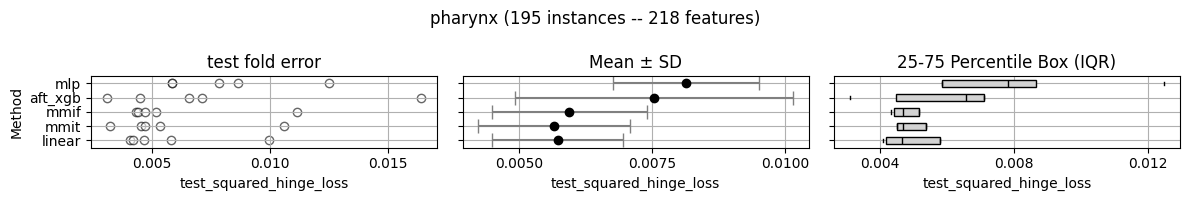

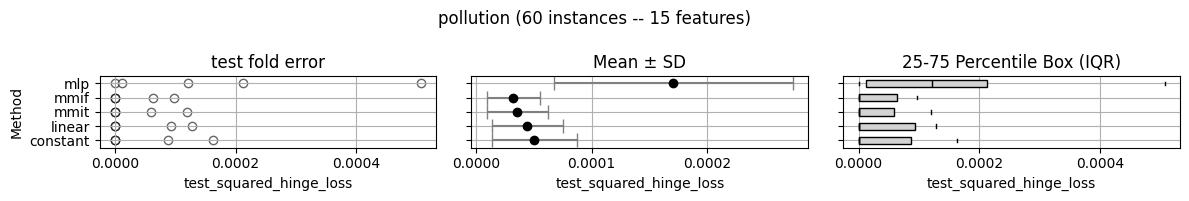

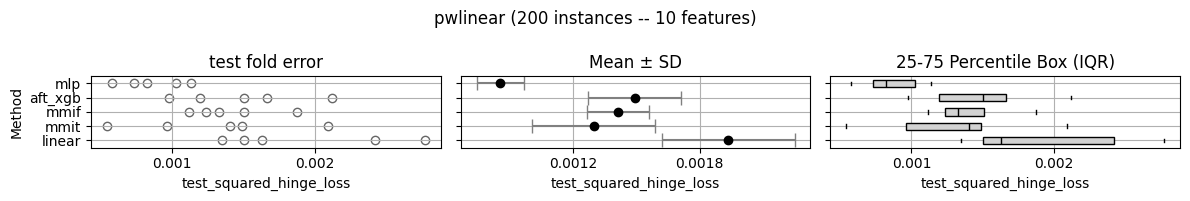

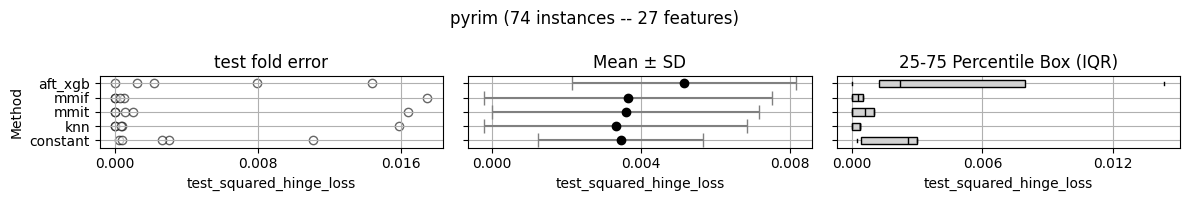

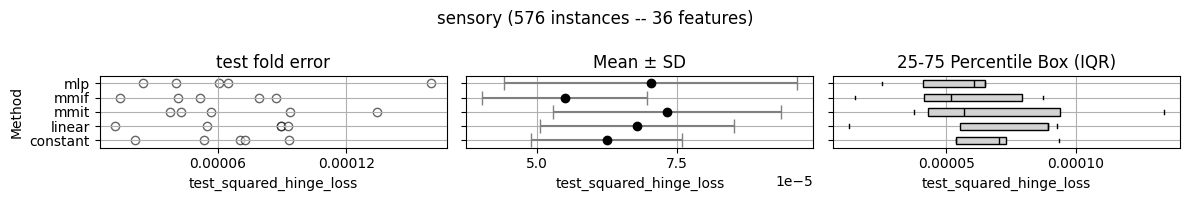

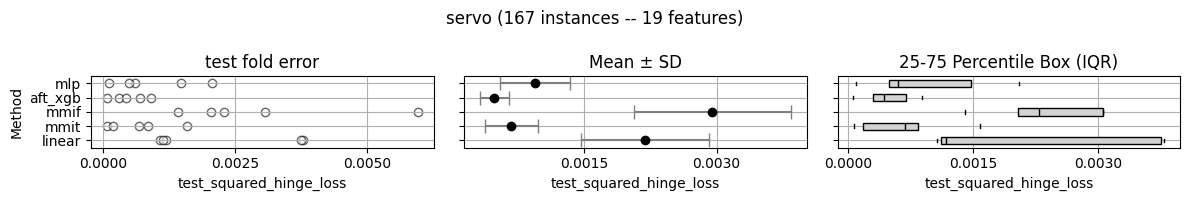

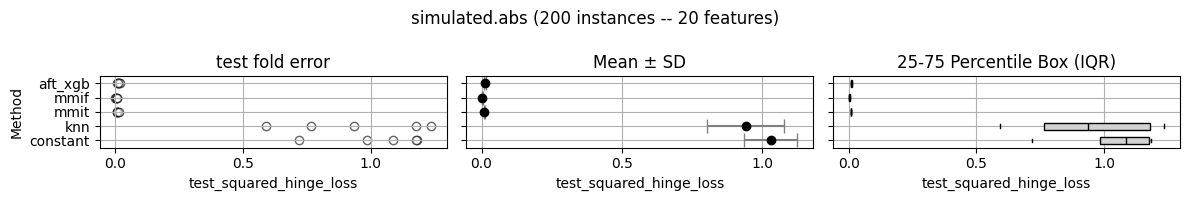

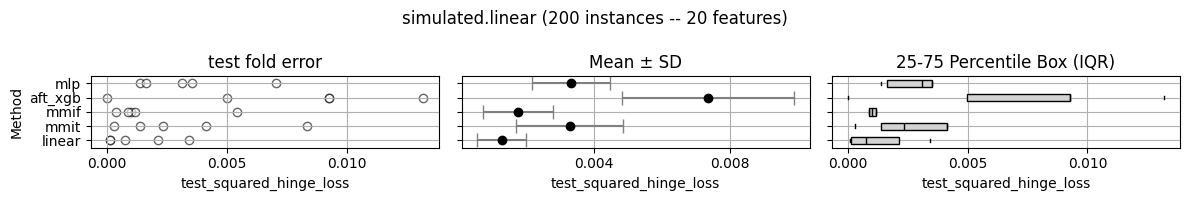

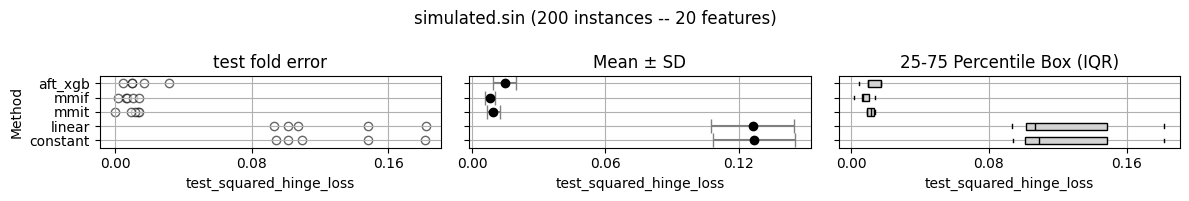

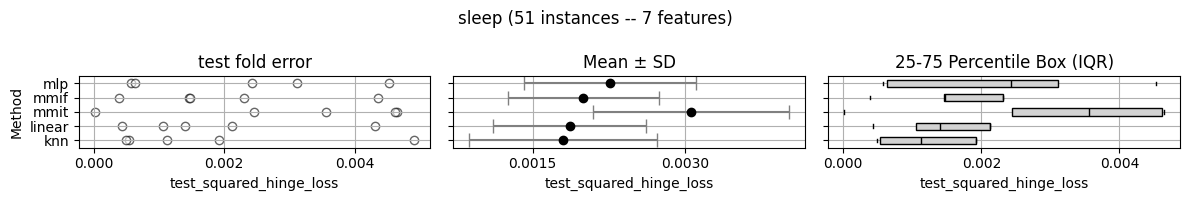

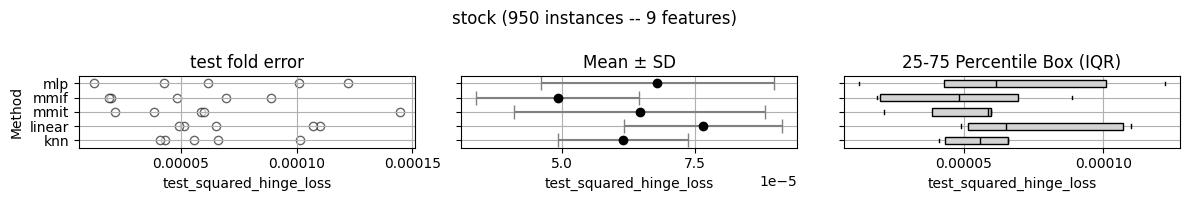

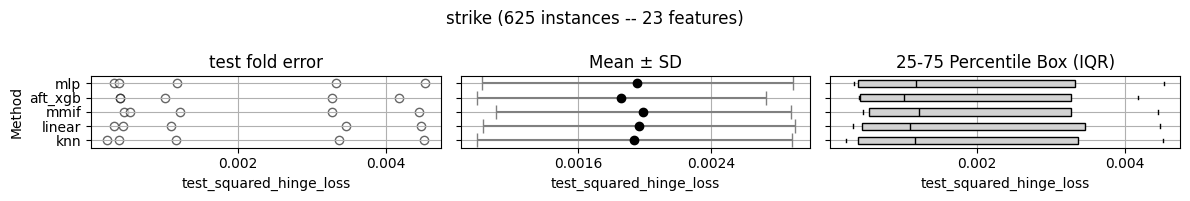

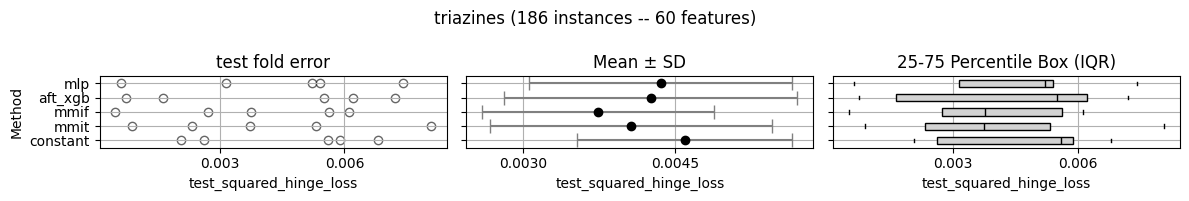

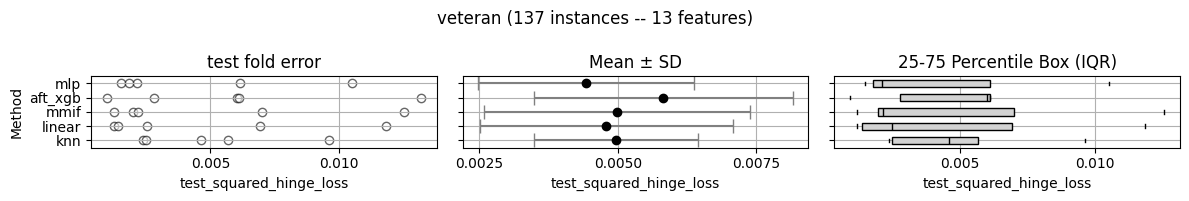

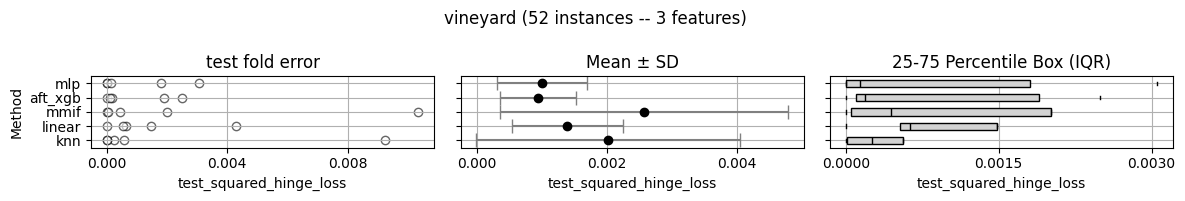

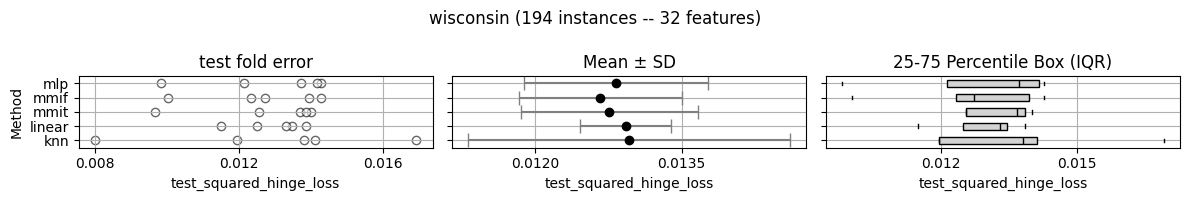

In [4]:
for dataset in datasets:
    plot(dataset, (12, 2))

In [5]:
# for dataset in ['simulated.linear', 'simulated.abs', 'simulated.sin']:
#     plot(dataset, (4,3))